In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
from dope.fetcher.llama import Llama
from dope.market_impact.linear import LinearMktImpactModel

# Load Raw Data

In [3]:
from dope.backengine.maestro import BackEngineMaestro, BacktestData

In [4]:
from dope.backengine.maestro import BackEngineMaestro, BacktestData
#maestro = BackEngineMaestro(tokens=["USDC", "USDT"], chain=BackEngineMaestro.chains.ethereum)
maestro = BackEngineMaestro()

In [13]:
starting_pools = """
https://defillama.com/yields/pool/aa70268e-4b52-42bf-a116-608b370f9501
https://defillama.com/yields/pool/a349fea4-d780-4e16-973e-70ca9b606db2
https://defillama.com/yields/pool/cefa9bb8-c230-459a-a855-3b94e96acd8c
"""
pool_urls = {}
pool_urls["USDC"] = """
#USDC
https://defillama.com/yields/pool/aa70268e-4b52-42bf-a116-608b370f9501
https://defillama.com/yields/pool/a349fea4-d780-4e16-973e-70ca9b606db2
https://defillama.com/yields/pool/4438dabc-7f0c-430b-8136-2722711ae663
https://defillama.com/yields/pool/7da72d09-56ca-4ec5-a45f-59114353e487
https://defillama.com/yields/pool/cefa9bb8-c230-459a-a855-3b94e96acd8c
https://defillama.com/yields/pool/2d1aa052-64c0-4c2c-82a0-db39062f04ab
https://defillama.com/yields/pool/a44febf3-34f6-4cd5-8ab1-f246ebe49f9e
https://defillama.com/yields/pool/7d114ce1-2af1-42c3-a719-406fbbc3ed92
https://defillama.com/yields/pool/468e4c2c-02df-427a-b2c7-5cea3a77014a
https://defillama.com/yields/pool/ab439af4-9978-4542-bc65-2772dfb79e50
https://defillama.com/yields/pool/ab12cc0f-4296-488e-9ad9-4014d1fadf13
https://defillama.com/yields/pool/d31fe043-5d45-4c31-a404-6d971749d678
https://defillama.com/yields/pool/bd5f0157-491d-4d2b-a966-7f7bb5ca0331
https://defillama.com/yields/pool/1b532a84-38ab-4e80-8bd2-94f062810ac4
"""
pool_urls["USDT"] = """
# USDT
https://defillama.com/yields/pool/f981a304-bb6c-45b8-b0c5-fd2f515ad23a
https://defillama.com/yields/pool/4e8cc592-c8d5-4824-8155-128ba521e903
https://defillama.com/yields/pool/60d657c9-5f63-4771-a85b-2cf8d507ec00
https://defillama.com/yields/pool/c037a916-a462-4c65-b217-100db0fdc0e0
https://defillama.com/yields/pool/57647093-2868-4e65-97ab-9cae8ec74e7d
https://defillama.com/yields/pool/043a8330-bc29-4164-aa1c-28de7bf87755
https://defillama.com/yields/pool/4cecbdfa-7189-4801-88ef-cdfee4b23298
https://defillama.com/yields/pool/a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79
https://defillama.com/yields/pool/4ce0c458-2171-463b-92ce-458afe367a4e
# https://defillama.com/yields/pool/2bad58b8-13f6-41c6-9245-a9dc1ea85be9
https://defillama.com/yields/pool/edaefc40-d818-48bd-a87a-d9c87598c1bc
https://defillama.com/yields/pool/1350803f-262c-4c7e-b134-d2f693c7a7c8
# https://defillama.com/yields/pool/6bb4b00c-188f-41a0-8b2d-96ce2a531622
https://defillama.com/yields/pool/c88d4008-f567-44e6-8ac8-a56d4f765a62
# https://defillama.com/yields/pool/e43ddfa2-5e6b-40b2-ae74-d01e1a1c10b8
# https://defillama.com/yields/pool/f4bb0e79-07b9-434a-9340-a5da72e7ff9e
https://defillama.com/yields/pool/612af285-321a-4295-8362-59a6113da145
"""
pool_urls["DAI"] = """
#DAI
https://defillama.com/yields/pool/30347261-b48b-4781-b394-081e630d49a9
https://defillama.com/yields/pool/c0921c0f-51aa-45b8-87e3-5eec59a6972b
https://defillama.com/yields/pool/45ef8c9e-bab3-44ae-bcf1-3c38044e0399
https://defillama.com/yields/pool/51de19bd-d2a6-420e-9bbd-350c967b23d0
https://defillama.com/yields/pool/feac7518-a0a7-4378-ba79-b1b9f4293525
https://defillama.com/yields/pool/cc110152-36c2-4e10-9c12-c5b4eb662143
https://defillama.com/yields/pool/405d8dad-5c99-4c91-90d3-82813ade1ff1
https://defillama.com/yields/pool/94ddaaae-75ef-43b4-8d42-f9b9aa4c8bd2
https://defillama.com/yields/pool/3665ee7e-6c5d-49d9-abb7-c47ab5d9d4ac
https://defillama.com/yields/pool/76ecf5e6-d906-49ac-af62-b8fa9f7f3222
https://defillama.com/yields/pool/f93997bb-1a54-45fa-908a-532cd5b142fa
https://defillama.com/yields/pool/6f8cb9ec-67d5-4a0b-b5d6-62f53d5f140c
https://defillama.com/yields/pool/de41ac69-f43f-4b39-a883-8dbf7b738988
https://defillama.com/yields/pool/3a8a33a5-5422-4f5e-a661-3cdbfe531e51
# https://defillama.com/yields/pool/b34a886f-fafe-4252-b141-71eae1839ebc
# https://defillama.com/yields/pool/db7b0fc0-1d55-4015-819e-b08faea4887f
"""


In [10]:
borrow_dfs = {}

In [35]:
token = "USDC"
pool_ids = [url.split("/")[-1] 
            for url in pool_urls[token].split("\n") 
            if "defillama.com" in url if "#" not in url]
pool_ids

_, tmp_borrow_lend_data = maestro.load_defilama_with_token_pool_id(
token_pool_id_dict = {token: pool_ids },
start_period="2023-06-01"
)

borrow_dfs[token] = tmp_borrow_lend_data[token]

USDC
Ethereum:aave-v3:USDC aa70268e-4b52-42bf-a116-608b370f9501 463 463
Ethereum:compound-v3:USDC 7da72d09-56ca-4ec5-a45f-59114353e487 461 461
Ethereum:fluid:USDC 4438dabc-7f0c-430b-8136-2722711ae663 99 99
Ethereum:morpho-blue(LTV: 86%):WBTC-USDC 2d1aa052-64c0-4c2c-82a0-db39062f04ab 203 203
Ethereum:morpho-blue(LTV: 86%):WSTETH-USDC 7d114ce1-2af1-42c3-a719-406fbbc3ed92 203 203
Ethereum:morpho-blue(LTV: 100%):GTUSDCCORE 468e4c2c-02df-427a-b2c7-5cea3a77014a 101 101
Ethereum:compound-v2:USDC cefa9bb8-c230-459a-a855-3b94e96acd8c 463 463
Ethereum:morpho-blue(LTV: 100%):STEAKUSDC a44febf3-34f6-4cd5-8ab1-f246ebe49f9e 101 101
Ethereum:morpho-blue(LTV: 77%):MKR-USDC bd5f0157-491d-4d2b-a966-7f7bb5ca0331 158 158
Ethereum:morpho-blue(LTV: 100%):GTUSDC ab439af4-9978-4542-bc65-2772dfb79e50 101 101
Ethereum:aave-v2:USDC a349fea4-d780-4e16-973e-70ca9b606db2 461 461
Ethereum:gearbox:USDC 1b532a84-38ab-4e80-8bd2-94f062810ac4 218 218
Ethereum:morpho-blue(LTV: 100%):USDCRWA ab12cc0f-4296-488e-9ad9-4014d1f

In [38]:
token = "DAI"
pool_ids = [url.split("/")[-1] 
            for url in pool_urls[token].split("\n") 
            if "defillama.com" in url if "#" not in url]
pool_ids

_, borrow_lend_data = maestro.load_defilama_with_token_pool_id(
token_pool_id_dict = {token: pool_ids },
start_period="2023-06-01"
)

borrow_dfs[token] = borrow_lend_data[token]

DAI
Ethereum:morpho-blue(LTV: 100%):SPDAI 30347261-b48b-4781-b394-081e630d49a9 101 101
Ethereum:morpho-blue(LTV: 86%):SUSDE-DAI c0921c0f-51aa-45b8-87e3-5eec59a6972b 161 161
Ethereum:morpho-blue(LTV: 86%):USDE-DAI 45ef8c9e-bab3-44ae-bcf1-3c38044e0399 161 161
Ethereum:morpho-blue(LTV: 91.5%):USDE-DAI feac7518-a0a7-4378-ba79-b1b9f4293525 163 163
Ethereum:morpho-blue(LTV: 91.5%):SUSDE-DAI 51de19bd-d2a6-420e-9bbd-350c967b23d0 164 164
Ethereum:compound-v2:DAI cc110152-36c2-4e10-9c12-c5b4eb662143 463 463
Ethereum:aave-v3:DAI 3665ee7e-6c5d-49d9-abb7-c47ab5d9d4ac 463 463
Ethereum:aave-v2:DAI 405d8dad-5c99-4c91-90d3-82813ade1ff1 461 461
Ethereum:morpho-blue(LTV: 77%):USDE-DAI 94ddaaae-75ef-43b4-8d42-f9b9aa4c8bd2 161 161
Ethereum:gearbox:DAI 6f8cb9ec-67d5-4a0b-b5d6-62f53d5f140c 155 155
Ethereum:morpho-blue(LTV: 77%):SUSDE-DAI de41ac69-f43f-4b39-a883-8dbf7b738988 161 161
Ethereum:morpho-blue(LTV: 94.5%):USDE-DAI 76ecf5e6-d906-49ac-af62-b8fa9f7f3222 162 162
Ethereum:morpho-blue(LTV: 94.5%):SUSDE-DA

In [39]:
token = "USDT"
pool_ids = [url.split("/")[-1] 
            for url in pool_urls[token].split("\n") 
            if "defillama.com" in url if "#" not in url]
pool_ids

_, borrow_lend_data = maestro.load_defilama_with_token_pool_id(
token_pool_id_dict = {token: pool_ids },
start_period="2023-06-01"
)

borrow_dfs[token] = borrow_lend_data[token]

USDT
Ethereum:aave-v3:USDT f981a304-bb6c-45b8-b0c5-fd2f515ad23a 463 463
Ethereum:fluid:USDT 4e8cc592-c8d5-4824-8155-128ba521e903 99 99
Ethereum:compound-v2:USDT 57647093-2868-4e65-97ab-9cae8ec74e7d 463 463
Ethereum:morpho-blue(LTV: 86%):WBTC-USDT c037a916-a462-4c65-b217-100db0fdc0e0 203 203
Ethereum:aave-v2:USDT 60d657c9-5f63-4771-a85b-2cf8d507ec00 461 461
Ethereum:morpho-blue(LTV: 100%):BBUSDT 043a8330-bc29-4164-aa1c-28de7bf87755 101 101
Ethereum:morpho-blue(LTV: 86%):WSTETH-USDT 4ce0c458-2171-463b-92ce-458afe367a4e 203 203
Ethereum:morpho-blue(LTV: 100%):GTUSDT 4cecbdfa-7189-4801-88ef-cdfee4b23298 101 101
Ethereum:morpho-blue(LTV: 91.5%):SUSDE-USDT a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79 166 166
Ethereum:morpho-blue(LTV: 100%):RE7USDT 1350803f-262c-4c7e-b134-d2f693c7a7c8 101 101
Ethereum:gearbox:USDT edaefc40-d818-48bd-a87a-d9c87598c1bc 155 155
Ethereum:morpho-blue(LTV: 91.5%):USDE-USDT c88d4008-f567-44e6-8ac8-a56d4f765a62 162 162


In [54]:
borrow_lend_data = BacktestData(borrow_dfs)

In [55]:
borrow_lend_data.to_block("USDT").apyBase[["Ethereum:aave-v3:USDT"]]

datetime,Ethereum:aave-v3:USDT
datetime,
2023-06-01,2.34972
2023-06-02,2.41449
2023-06-03,2.27674
2023-06-04,2.29288
2023-06-05,1.99245
...,...
2024-09-01,3.75192
2024-09-02,3.71567
2024-09-03,3.55673


In [43]:
ls ~/s3/fusion/backtest-data/

2024-06-03-main-chain-daily-triggers-daily-data-many-protocols/
arb/
arb-data-03-07-2024/
main-chain-daily-triggers-hourly-data/
multi-chain-arb-daily-triggers/
multi-chain-arb-daily-triggers-arb-only/
multi-chain-hourly-run/
multi-chain-hourly-run-positive-only/
multi-chain-hourly-run-v0.1/
multi-chain-hourly-triggers/
multi-chain-hourly-triggers-more-tokens/
optimization+stable-arb-many-protocols/
stable-arb-data-05-09-2024/
stable-arb-many-protocols/


In [ ]:
# Save/from to/from disk if needed.

In [56]:
# borrow_lend_data.dump("stable-arb-data-05-09-2024")

# borrow_lend_data = BacktestData.load("stable-arb-data-05-09-2024")

In [57]:
borrow_lend_data.to_block("USDT").apyBase[["Ethereum:aave-v3:USDT"]]

datetime,Ethereum:aave-v3:USDT
datetime,
2023-06-01,2.34972
2023-06-02,2.41449
2023-06-03,2.27674
2023-06-04,2.29288
2023-06-05,1.99245
...,...
2024-09-01,3.75192
2024-09-02,3.71567
2024-09-03,3.55673


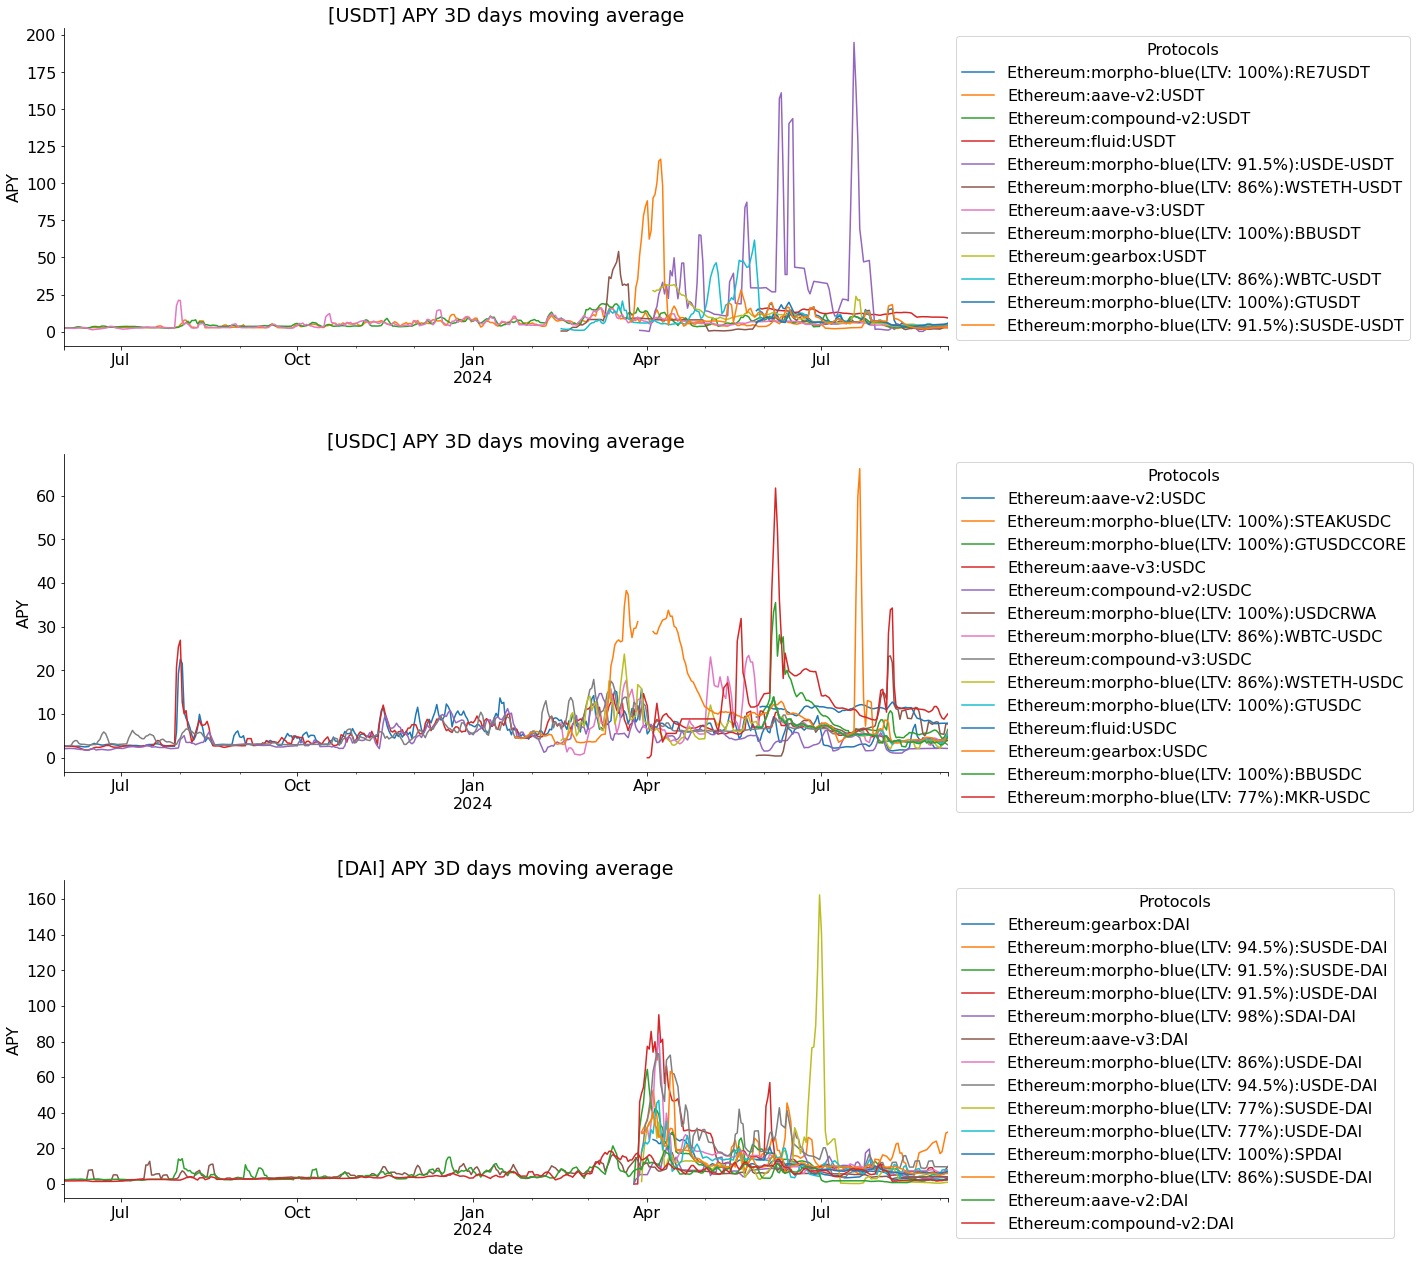

In [62]:
maestro.set_data(borrow_lend_data)
maestro.plot_rates_ts( figsize_xy=(20,6), agg_str='3D',)

# Prep Arb Data

In [63]:
from dope.backengine.naive_arb import NaiveArbBacktest
from dope.backengine.agents.jackreaper import LenderJackReaper

In [64]:
from dope.backengine.arbengine import ArbBacktester
from dope.market_impact.linear import LinearMktImpactModel
from dope.backengine.agents.arb import ArbStrategy

from dope.backengine.agents.jackreaper import LenderJackReaper
from dope.backengine.agents.quadratic import LenderQuadratic


from dope.backengine.runsummary import BacktestSummary

In [65]:
mkt_impact = {mkt:LinearMktImpactModel.zero_instance() 
 for _data in borrow_lend_data[token].values()
 for mkt in _data.keys()
}

In [27]:
# from dope.backengine.agents.txcosts import LenderMIQP
# import importlib
# from dope.backengine.agents import txcosts

# # Force reload the module
# importlib.reload(txcosts)

# # Now you can use the reloaded class
# from dope.backengine.agents.txcosts import LenderMIQP


In [578]:
base_token = "USDC"
token = base_token
enhanced_borrow_lend_data = {token:{} for token in borrow_lend_data.keys()}
for token in borrow_lend_data.keys():
  for mkt in borrow_lend_data[token].keys():
    enhanced_borrow_lend_data[token][mkt] = borrow_lend_data[token][mkt].resample("1H").last().interpolate()

from dope.backengine.maestro import BacktestData
  
enhanced_borrow_lend_data = BacktestData(enhanced_borrow_lend_data)

In [67]:
arb_run_data = borrow_lend_data
#arb_run_data = enhanced_borrow_lend_data

In [143]:
pay = "apyBaseBorrow"
rec = "apyBase"

base_token = "USDC" # Starting Token
dfs = {base_token:{}}
TOKENS = arb_run_data.keys()
TOKENS = [t for t in TOKENS if base_token != t]

single_mkts = [mkt for mkt in arb_run_data[base_token].keys()  if base_token in mkt]

# uncomment below to add single markets
for mkt in single_mkts:
  # dfs[base_token][mkt] = arb_run_data[base_token][mkt]
  # print(len(dfs[base_token]), mkt)
  pass 

for mkt in arb_run_data[base_token].keys():
  #print(mkt)
  if base_token not in mkt:
    continue
  if not any(["aave-v2" in mkt, "aave-v3" in mkt, "compound-v2" in mkt]):
    continue
  if "cash" in mkt:
    continue
  chain_protocol = mkt.split(":")[:2]
  chain_protocol = ":".join(chain_protocol)
  rec_base = arb_run_data[base_token][mkt][rec]
  
  for arb_token in TOKENS:
    mkt_to_pay_arb = chain_protocol + ":" + arb_token
    # print(f"{mkt_to_pay_arb = }")
    if not (mkt_to_pay_arb in arb_run_data[arb_token]):
      continue

    pay_arb = arb_run_data[arb_token][mkt_to_pay_arb][pay]
    for mkt_to_rec_arb in arb_run_data[arb_token]:
      if "cash" in mkt_to_rec_arb:
        continue
      rec_arb = arb_run_data[arb_token][mkt_to_rec_arb][rec]
      _strat_name = f"{mkt}-{mkt_to_pay_arb}+{mkt_to_rec_arb}"
      dfs[base_token][_strat_name] = pd.DataFrame(rec_base - pay_arb + rec_arb, columns=[rec])
      dfs[base_token][_strat_name]["utilizationRate"] = 0.5
      print(len(dfs[base_token]), _strat_name, )

run_data = BacktestData(dfs)
run_data.add_cash_mkt()

#mkt_impact_zeros = {k:LinearMktImpactModel.zero_instance() for k in run_data[base_token].keys()}
#mkt_impact_zeros["cash"] = LinearMktImpactModel.zero_instance()

1 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 100%):RE7USDT
2 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:aave-v2:USDT
3 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:compound-v2:USDT
4 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:fluid:USDT
5 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 91.5%):USDE-USDT
6 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 86%):WSTETH-USDT
7 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:aave-v3:USDT
8 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 100%):BBUSDT
9 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:gearbox:USDT
10 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 86%):WBTC-USDT
11 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 100%):GTUSDT
12 Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+Ethereum:morpho-blue(LTV: 91.5%):SUSDE-USDT
13 Ethereum:aave-v2:USDC-Ethereum:aave-v2:DA

# Backtest

In [99]:
summaries = {}
ws = {}
CAPITAL = 500_000

In [101]:
from dope.backengine.agents.txcosts import LenderMIQP
from dope.backengine.agents.mktetf import LenderMKTETF

strategy = LenderMIQP(token=base_token, capital=CAPITAL, risk_aversion=-0.1, mean_window=1, cov_window=3)
arbt = ArbBacktester(strategy=strategy, borrow_lend_data=run_data, data=run_data, mkt_impact=mkt_impact)
# strategy.register_engine(arbt)

In [ ]:
arbt()

In [148]:
triggers = run_data.to_block(base_token).utilizationRate.resample("7D").last().index[1:]
len(triggers)

66

In [103]:

summaries = {}

λ = 0
d = 1

end_timestamp = "2023-12-01"

start_timestamp = "2024-01-01"
end_timestamp = "2024-03-10"
end_timestamp = None
start_timestamp = None

TRIGGERS = triggers
#TRIGGERS = _triggers
#TRIGGERS = None


CAPITAL = 1

In [104]:
# run_name = "stable-arb-many-protocols"
# BacktestSummary(run_name, summaries, run_data).dump()

In [105]:
%%time
strategy = LenderJackReaper(token=base_token, capital=CAPITAL, days_window=d, parts=10, triggers=TRIGGERS,)
strategy.verbose = False
arbt = ArbBacktester(strategy=strategy, borrow_lend_data=run_data, data=run_data)
summaries[base_token+f":jackreaper:{d}d"], _ = arbt(end_timestamp=end_timestamp, start_timestamp=start_timestamp)

# Save Backtest
run_name = "stable-arb-run"
BacktestSummary(run_name, summaries, run_data).dump()

Running Backtest for 463 | token:USDC
CPU times: user 24.5 s, sys: 2.33 s, total: 26.8 s
Wall time: 26.2 s


In [151]:
summaries[base_token+f":jackreaper:{d}d"]

,timestamp,ws,rate,capital,breakdown,mkt_impact
datetime,,,,,,
2023-06-03,2023-06-03,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,1.47819,1.000040,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
2023-06-04,2023-06-04,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,1.50973,1.000082,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
2023-06-05,2023-06-05,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,1.38074,1.000120,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
2023-06-06,2023-06-06,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,1.61530,1.000164,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
2023-06-07,2023-06-07,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,1.42258,1.000203,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
...,...,...,...,...,...,...
2024-09-01,2024-09-01,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,11.44063,1.246872,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
2024-09-02,2024-09-02,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,26.39635,1.247773,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...
2024-09-03,2024-09-03,{'USDC': {'Ethereum:aave-v2:USDC-Ethereum:aave...,26.46045,1.248678,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...,{'Ethereum:aave-v2:USDC-Ethereum:aave-v2:USDT+...


# Analysis 

In [106]:
from dope.backengine.plotting.fofarticle import Plotter

In [146]:
run_name = "stable-arb-run"
run = BacktestSummary.load(run_name)
plot = Plotter(run.to_block())

## Backtest results

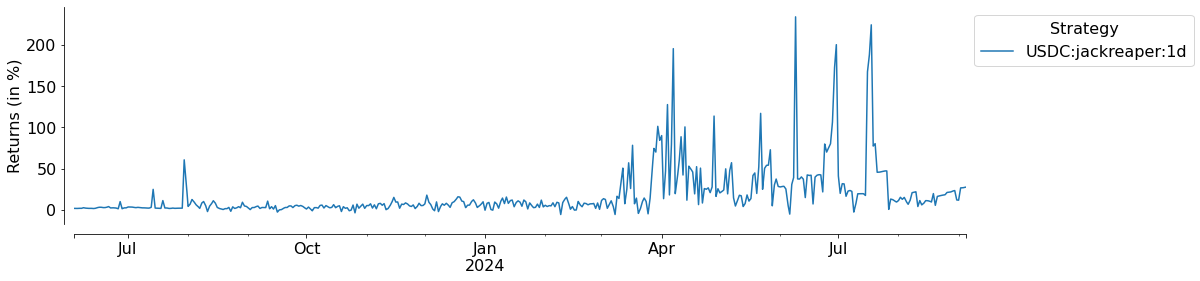

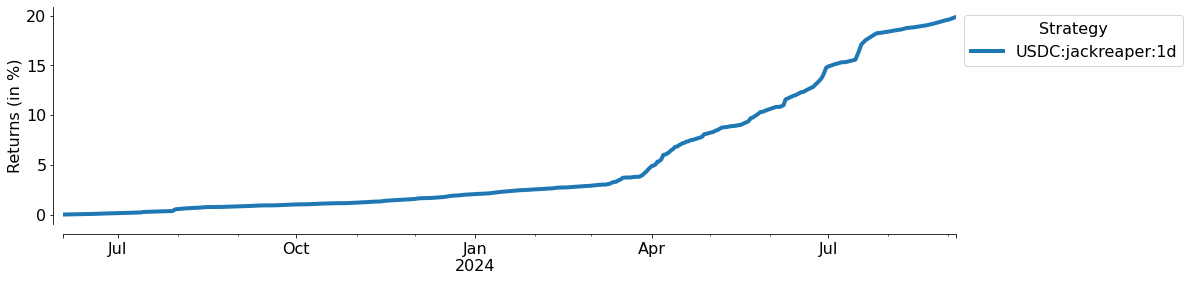

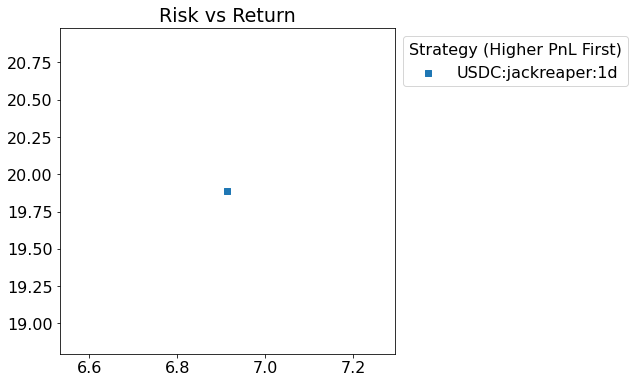

datetime
USDC:jackreaper:1d    19.889399
dtype: float64


In [147]:
plot.summary_view()

## Arb Routes

<Figure size 1440x504 with 0 Axes>

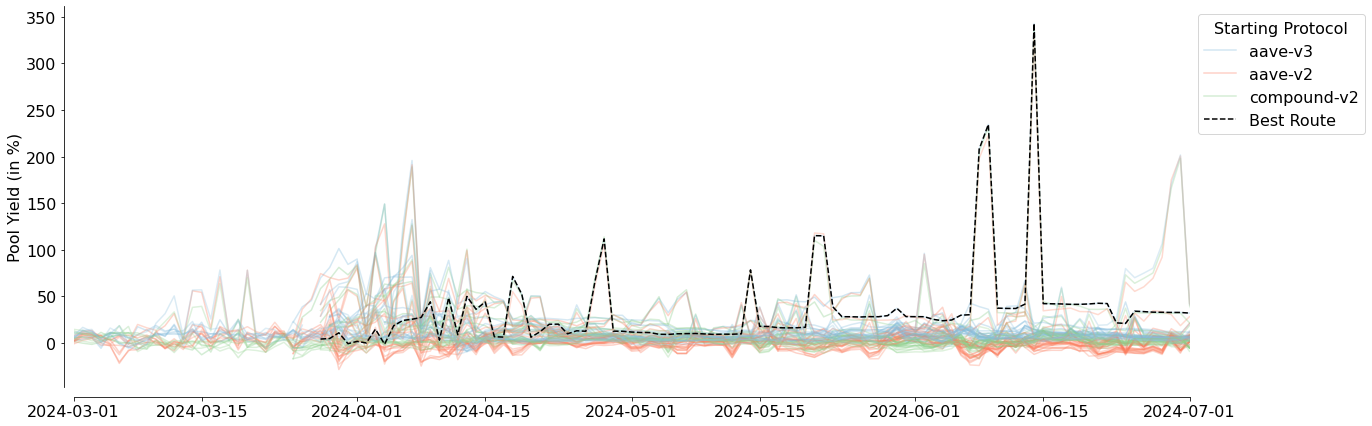

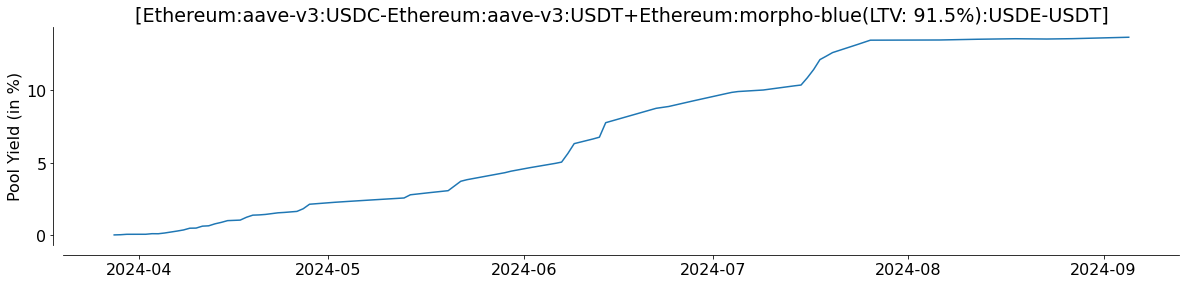

In [130]:
plot.plot_arb_routes(run, xlim=("2024-03-01", "2024-07-01"))